<a href="https://colab.research.google.com/github/fahaerte/LSIES-FinalAssignment/blob/main/Task4_DataAssimilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Environment variables
drive = True
install_packages = True

# If necessary, install packages
if install_packages:
  !pip install Basemap basemap-data-hires
  !pip install pandas matplotlib numpy
  !pip install sklearn
  !pip install datetime
  !pip install AutoTS

# Imports
import os
import pandas as pd
import numpy as np
from csv import reader
from sklearn.metrics import r2_score
from datetime import datetime
from datetime import timedelta as tdelta
from datetime import time as time
from autots import AutoTS
from sklearn.linear_model import LinearRegression
import warnings

# Mount drive if needed
if drive:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Colab\ Notebooks/LSIES

from Helper_funcs import *
from SensorPositions_Func import *
from SVD_Func import *

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Depending on the environemnt, set directory to data
if drive:
  dir_path = '/content/drive/MyDrive/data/'
else :
  dir_path = './data/'

folders = ['region_1_mustamäe_kristiine', 'region_2_data_kesklinn', 'region_3_kadriorg_lasnamäe', 'region_4_ülemiste']
csv_file_name_sensor_positions = 'sensor_positions.csv'
columns_sensors_positions = ['sensor_name', 'latitude', 'longitude', 'region']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.6/860.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 121.9 MB/s eta 0:00:00


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-p

In [2]:
#Import data
df_data_linear = pd.read_csv(dir_path + 'interpolated_data_1.csv')
df_data_linear.drop('Unnamed: 0.1', axis=1, inplace=True)
df_data_linear['Unnamed: 0'] = df_data_linear.apply(lambda row: datetime.strptime(row['Unnamed: 0'], '%Y-%m-%d %H:%M:%S'), axis=1)
df_data_linear.set_index('Unnamed: 0', inplace=True)
df_data_linear.index.name = None

In [3]:
# Compute indices of timestamps
day_index = compute_period_indices(df_data_linear, '07:00', '19:00')
evening_index = compute_period_indices(df_data_linear, '19:00', '23:00')
night_index = compute_period_indices(df_data_linear, '23:00', '7:00')

In [4]:
# Compute sensor regions
sensor_positions_df = import_sensor_positions(dir_path, csv_file_name_sensor_positions)
sensors_region1, sensors_region2, sensors_region3, sensors_region4 = get_sensors_based_on_region(sensor_positions_df)
del sensor_positions_df, csv_file_name_sensor_positions

In [5]:
# Filter data to obtain only sensors of region 4
data_region4 = df_data_linear[sensors_region4]
del sensors_region1, sensors_region2, sensors_region3, df_data_linear

In [6]:
# Compute average of region 4
data_region4['average'] = data_region4.mean(axis=1)

<ipython-input-6-a9b3cf132f02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_region4['average'] = data_region4.mean(axis=1)


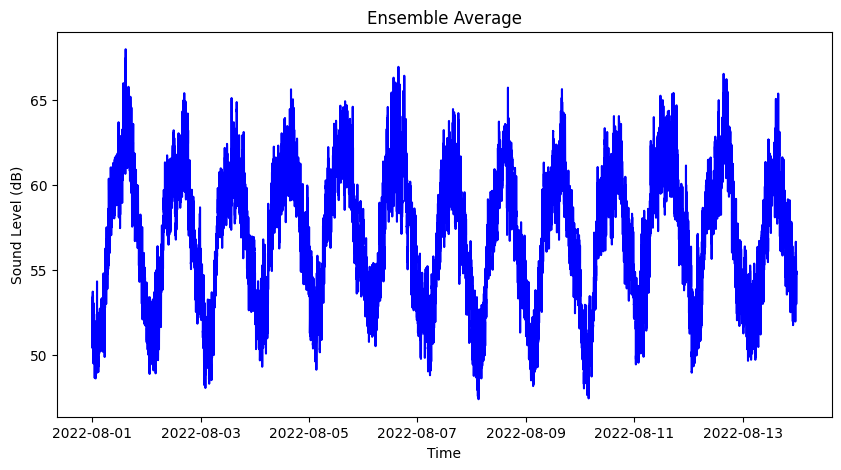

In [7]:
# Plot the ensemble average
plt.figure(figsize=(10,5))
plt.plot(data_region4.index, data_region4['average'],c='blue', label='Ensemble Average')
plt.title('Ensemble Average')
plt.xlabel('Time')
plt.ylabel('Sound Level (dB)')
plt.show()

Let's see how many times certain thresholds are exceeded on average

In [8]:
dba_thresholds = range(55, 70, 1)
cols=['threshold', 'period', '21C2', '221E', '2240', '225D', '2266', '2289', '2329', '2396']
exceeding_threshold_df = pd.DataFrame(columns=cols)
periods = ['day', 'evening', 'night']
indices = [day_index, evening_index, night_index]

for threshold in dba_thresholds:
    for period, index in zip(periods, indices):
        counts = (data_region4.iloc[index][data_region4 >= threshold].count() / index.shape[0] * 100).to_dict()
        counts['period'] = period
        counts['threshold'] = threshold
        exceeding_threshold_df = exceeding_threshold_df.append(counts, ignore_index=True)

exceeding_threshold_df['average'] = exceeding_threshold_df[cols[2:]].mean(axis=1)

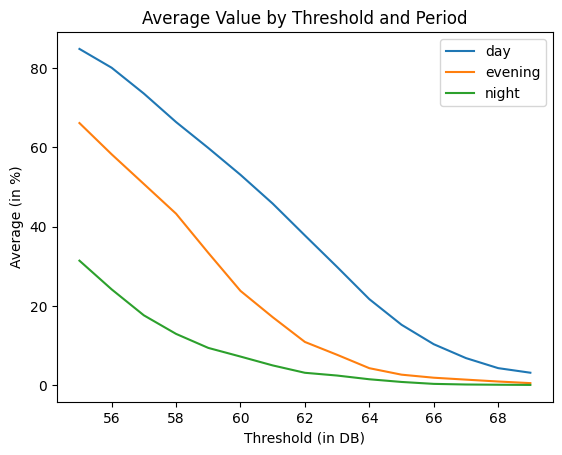

In [9]:
fig, ax = plt.subplots()
for p in exceeding_threshold_df['period'].unique():
  ax.plot(exceeding_threshold_df[exceeding_threshold_df['period']==p]['threshold'], exceeding_threshold_df[exceeding_threshold_df['period']==p]['average'], label=p)

ax.set_xlabel('Threshold (in DB)')
ax.set_ylabel('Average (in %)')
ax.set_title('Average Value by Threshold and Period')
ax.legend()
plt.show()

In [10]:
exceeding_threshold_df[exceeding_threshold_df['threshold'] == 65].groupby('period').sum()

,21C2,221E,2240,225D,2266,2289,2329,2396,average
period,,,,,,,,,
day,2.361111,7.660256,39.433761,25.448718,16.891026,4.262821,6.314103,19.358974,15.216346
evening,0.288462,1.506410,5.769231,4.615385,6.314103,0.160256,0.000000,2.307692,2.620192
night,2.179487,0.304487,1.682692,0.336538,1.570513,0.064103,0.000000,0.112179,0.781250


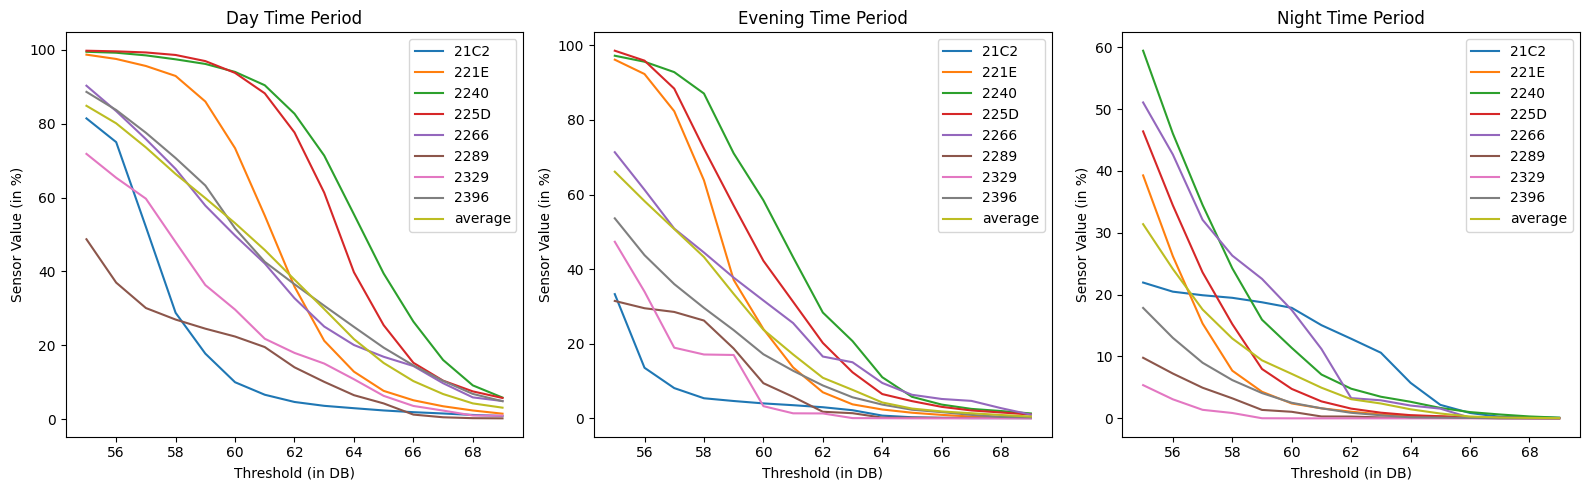

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

for period, ax in zip(exceeding_threshold_df['period'].unique(), axs):
    df_period = exceeding_threshold_df[exceeding_threshold_df['period'] == period]
    
    for sensor in df_period.columns[2:]:
        ax.plot(df_period['threshold'], df_period[sensor], label=sensor)
    
    ax.set_xlabel('Threshold (in DB)')
    ax.set_ylabel('Sensor Value (in %)')
    ax.set_title(f'{period.capitalize()} Time Period')
    ax.legend()

plt.tight_layout()
plt.show()

Probably, the noise disturbance on weekdays is different to the noise disturbance on the weekend. Let's consider it

In [12]:
exceeding_threshold_weekday_df = pd.DataFrame(columns=cols)
exceeding_threshold_weekend_df = pd.DataFrame(columns=cols)

for threshold in dba_thresholds:
    for period, index in zip(periods, indices):
      data_region4_period = data_region4.iloc[index]
      data_region4_weekday = data_region4_period[data_region4_period.index.dayofweek < 5]
      data_region4_weekend = data_region4_period[data_region4_period.index.dayofweek >= 5]
      counts_weekdays = (data_region4_weekday[data_region4_weekday >= threshold].count() / index.shape[0] * 100).to_dict()
      counts_weekends = (data_region4_weekend[data_region4_weekend >= threshold].count() / index.shape[0] * 100).to_dict()
      counts_weekdays['period'] = period
      counts_weekdays['threshold'] = threshold
      counts_weekends['period'] = period
      counts_weekends['threshold'] = threshold
      exceeding_threshold_weekday_df = exceeding_threshold_weekday_df.append(counts_weekdays, ignore_index=True)
      exceeding_threshold_weekend_df = exceeding_threshold_weekend_df.append(counts_weekends, ignore_index=True)

exceeding_threshold_weekday_df['average'] = exceeding_threshold_weekday_df[cols[2:]].mean(axis=1)
exceeding_threshold_weekend_df['average'] = exceeding_threshold_weekend_df[cols[2:]].mean(axis=1)

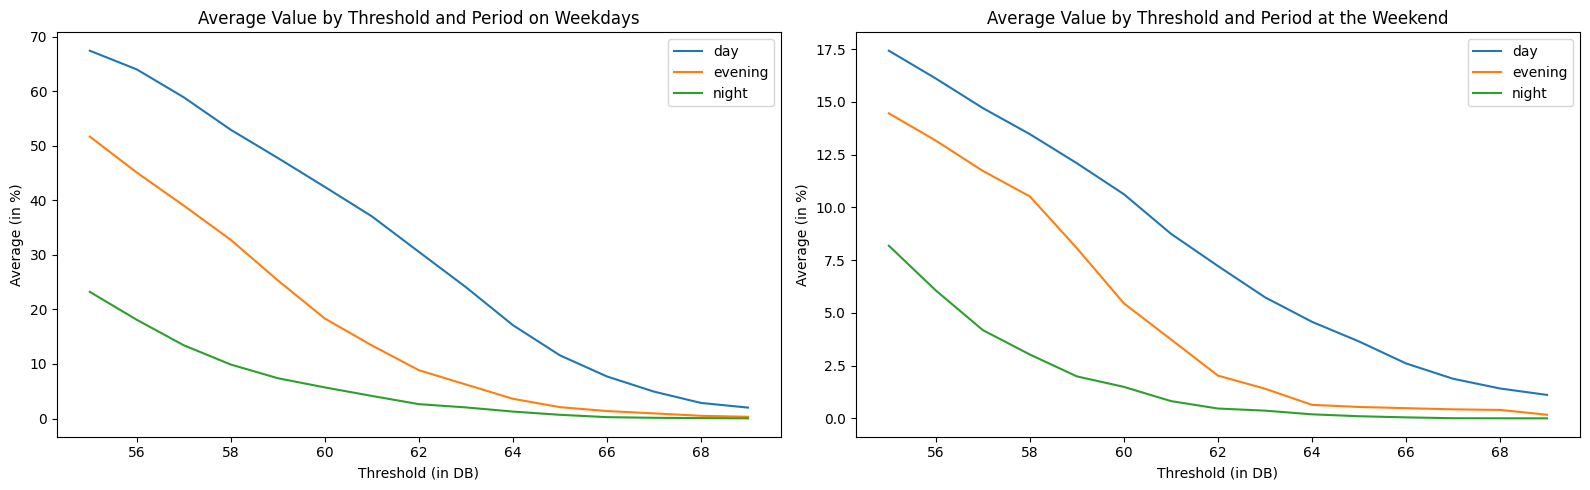

In [13]:
fig, axs = plt.subplots(1,2, figsize=(16, 5))
for p in exceeding_threshold_df['period'].unique():
  axs[0].plot(exceeding_threshold_weekday_df[exceeding_threshold_weekday_df['period']==p]['threshold'], exceeding_threshold_weekday_df[exceeding_threshold_weekday_df['period']==p]['average'], label=p)
  axs[1].plot(exceeding_threshold_weekend_df[exceeding_threshold_weekend_df['period']==p]['threshold'], exceeding_threshold_weekend_df[exceeding_threshold_weekend_df['period']==p]['average'], label=p)

axs[0].set_xlabel('Threshold (in DB)')
axs[0].set_ylabel('Average (in %)')
axs[0].set_title('Average Value by Threshold and Period on Weekdays')
axs[0].legend()
axs[1].set_xlabel('Threshold (in DB)')
axs[1].set_ylabel('Average (in %)')
axs[1].set_title('Average Value by Threshold and Period at the Weekend')
axs[1].legend()

plt.tight_layout()
plt.show()

In [14]:
exceeding_threshold_weekday_df[exceeding_threshold_weekday_df['threshold'] == 65].groupby('period').sum()

,21C2,221E,2240,225D,2266,2289,2329,2396,average
period,,,,,,,,,
day,1.987179,6.132479,31.250000,17.692308,11.869658,4.059829,4.476496,15.106838,11.571848
evening,0.288462,1.442308,5.000000,4.070513,3.557692,0.160256,0.000000,2.115385,2.079327
night,1.522436,0.304487,1.634615,0.320513,1.538462,0.032051,0.000000,0.080128,0.679087


In [15]:
exceeding_threshold_weekend_df[exceeding_threshold_weekend_df['threshold'] == 65].groupby('period').sum()

,21C2,221E,2240,225D,2266,2289,2329,2396,average
period,,,,,,,,,
day,0.373932,1.527778,8.183761,7.756410,5.021368,0.202991,1.837607,4.252137,3.644498
evening,0.000000,0.064103,0.769231,0.544872,2.756410,0.000000,0.000000,0.192308,0.540865
night,0.657051,0.000000,0.048077,0.016026,0.032051,0.032051,0.000000,0.032051,0.102163


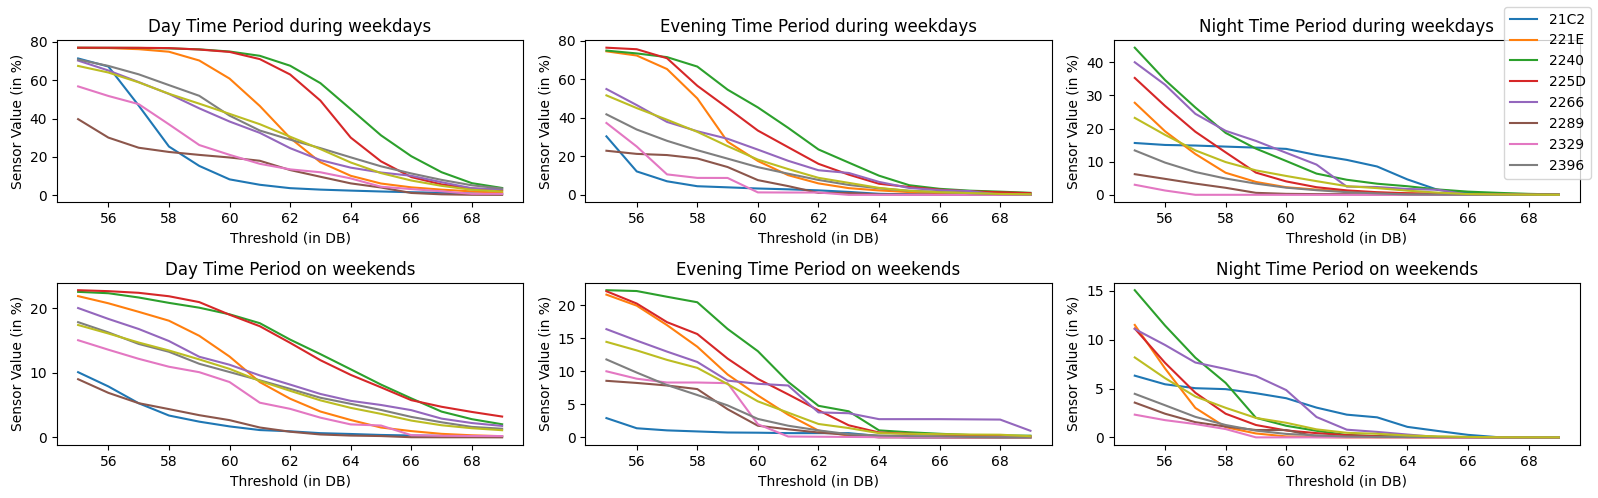

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(16, 5))

for period, ax in zip(exceeding_threshold_weekday_df['period'].unique(), axs[0]):
    df_period = exceeding_threshold_weekday_df[exceeding_threshold_weekday_df['period'] == period]
    
    for sensor in df_period.columns[2:]:
        ax.plot(df_period['threshold'], df_period[sensor], label=sensor)
    
    ax.set_xlabel('Threshold (in DB)')
    ax.set_ylabel('Sensor Value (in %)')
    ax.set_title(f'{period.capitalize()} Time Period during weekdays')

for period, ax in zip(exceeding_threshold_weekend_df['period'].unique(), axs[1]):
    df_period = exceeding_threshold_weekend_df[exceeding_threshold_weekend_df['period'] == period]
    
    for sensor in df_period.columns[2:]:
        ax.plot(df_period['threshold'], df_period[sensor], label=sensor)
    
    ax.set_xlabel('Threshold (in DB)')
    ax.set_ylabel('Sensor Value (in %)')
    ax.set_title(f'{period.capitalize()} Time Period on weekends')

fig.legend(cols[2:])
plt.tight_layout()
plt.show()

**DATA SMOOTHING**

In [17]:
window_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90]
data_smoothed = []

for window in window_sizes:
  data_region4_smoothed = pd.DataFrame()
  data_region4_smoothed = data_region4.rolling(window).mean()
  data_region4_smoothed = data_region4_smoothed[window - 1:] # Remove the first rows since they only contain NaN values
  data_smoothed.append(data_region4_smoothed)

data_smoothed[0].head()

,21C2,221E,2240,225D,2266,2289,2329,2396,average
2022-08-01 00:09:00,50.4,55.04,56.80,55.1,52.07,50.21,47.11,48.60,51.91625
2022-08-01 00:10:00,50.5,54.85,56.36,54.8,51.61,50.09,46.82,49.62,51.83125
2022-08-01 00:11:00,50.6,54.96,56.56,55.1,51.12,50.03,46.67,50.44,51.93500
2022-08-01 00:12:00,50.7,54.92,56.39,55.1,50.80,49.93,46.80,50.76,51.92500
2022-08-01 00:13:00,50.8,54.86,56.21,55.0,50.89,49.89,46.66,51.18,51.93625


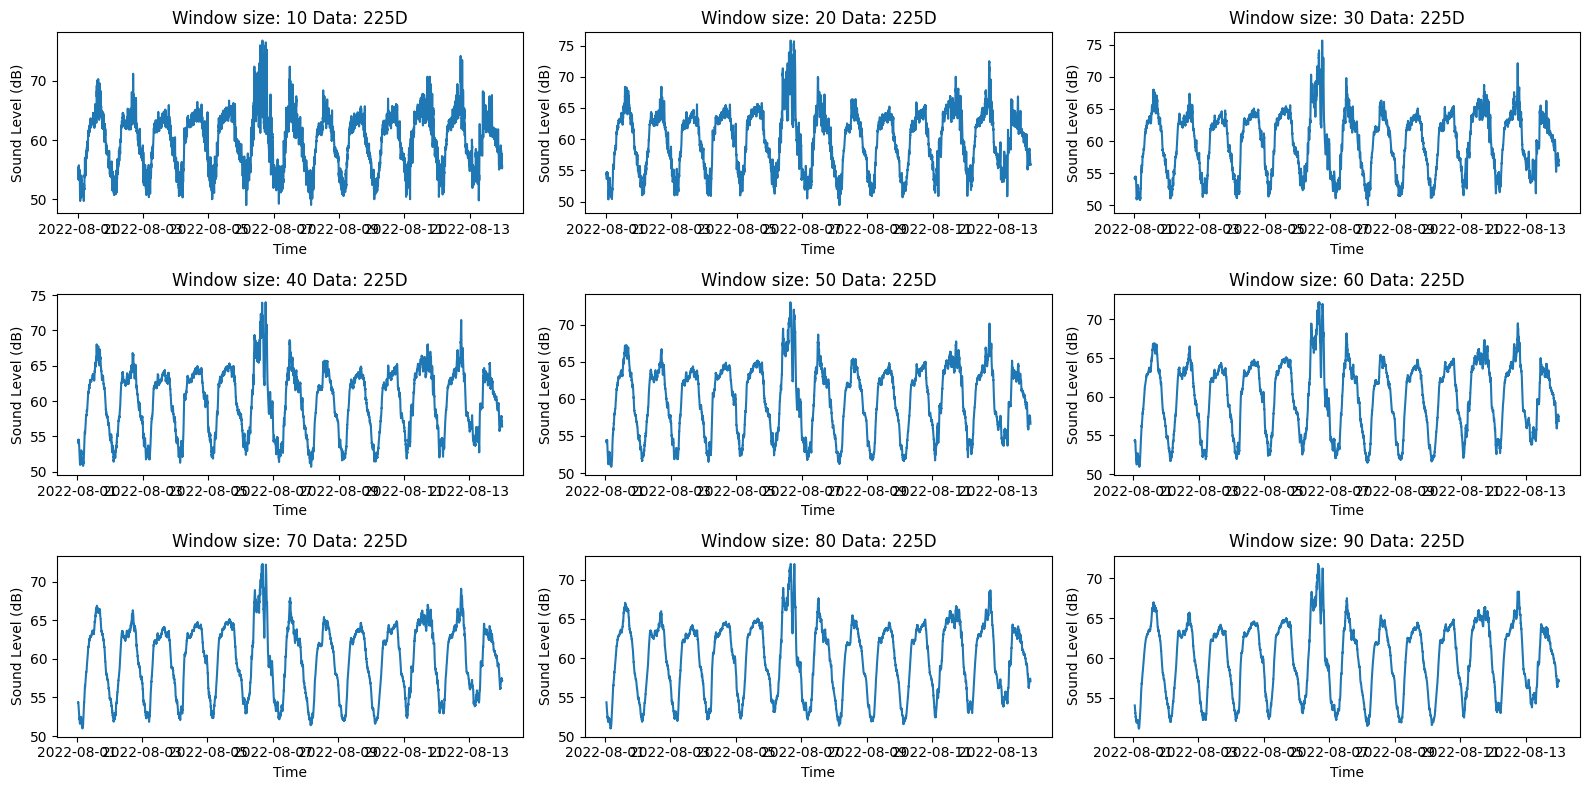

In [18]:
# Plot the smoothed ensemble average
col_to_plot = '225D'
windows_sizes_as_matrix = np.array(window_sizes).reshape(3,3)
fig, axs = plt.subplots(3, 3, figsize=(16, 8))
df_counter = 0

for w1 in range(0, len(windows_sizes_as_matrix)):
  for w2 in range(0, len(windows_sizes_as_matrix[w1])):
        axs[w1, w2].plot(data_smoothed[df_counter].index, data_smoothed[df_counter][col_to_plot])
        axs[w1, w2].set_xlabel('Time')
        axs[w1, w2].set_ylabel('Sound Level (dB)')
        axs[w1, w2].set_title(f'Window size: {windows_sizes_as_matrix[w1, w2]} Data: {col_to_plot}')
        df_counter = df_counter + 1

plt.tight_layout()
plt.show()

Data Smoothing using a window size of 30 minutes is enough to capture the overall trend of the data.

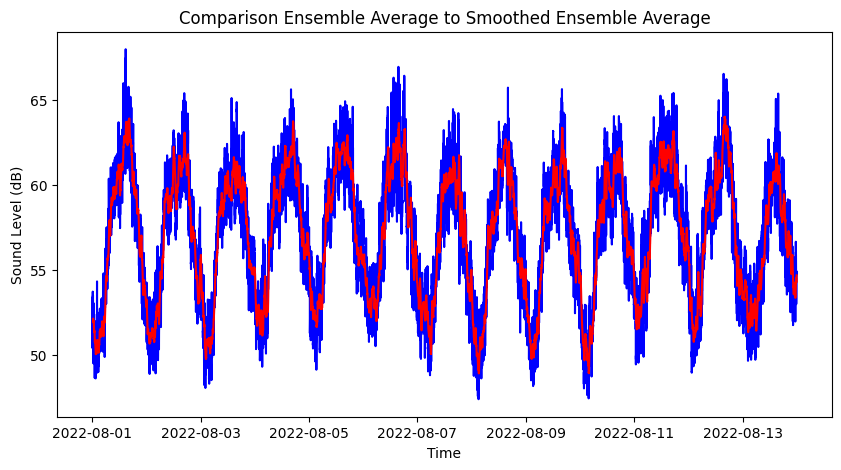

In [19]:
try:
    df_smoothed = data_smoothed[2]
    del data_smoothed, window_sizes, col_to_plot
except NameError:
    pass

plt.figure(figsize=(10,5))
plt.plot(data_region4.index, data_region4['average'],c='blue', label='Ensemble Average')
plt.plot(df_smoothed.index, df_smoothed['average'],c='red', label='Ensemble Average Smoothed')
plt.title('Comparison Ensemble Average to Smoothed Ensemble Average')
plt.xlabel('Time')
plt.ylabel('Sound Level (dB)')
plt.show()

**Data Assimilation - Linear Regression**

Choose 4 sensors next to the Railway station: 

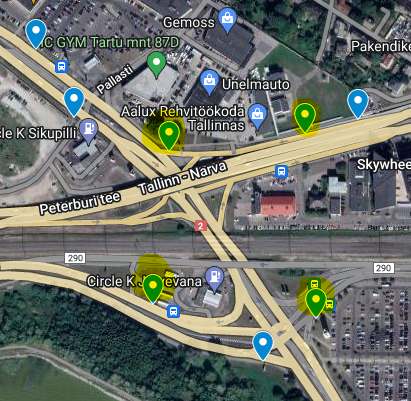

Chosen sensors: 225D, 2396, 2289, 2329

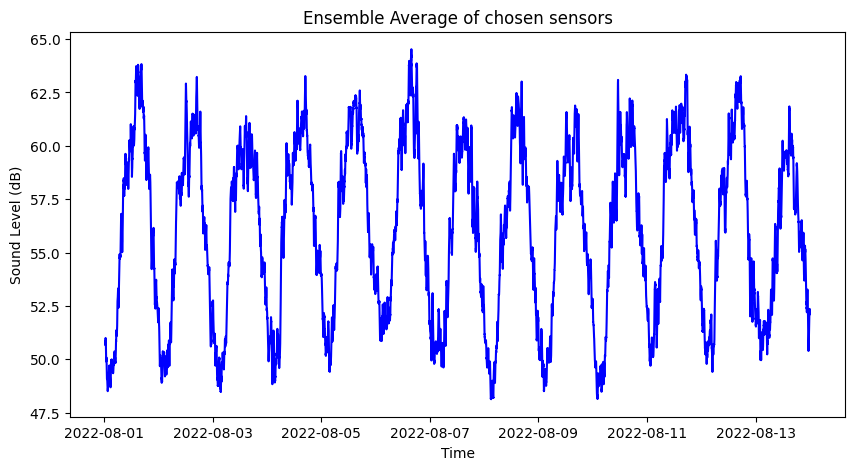

In [20]:
chosen_sensors = ['225D', '2396', '2289', '2329']

# Compute average of chosen sensor
df_chosen_sensors = df_smoothed.loc[:, chosen_sensors]
df_chosen_sensors['average'] = df_chosen_sensors.mean(axis=1)

plt.figure(figsize=(10,5))
plt.plot(df_chosen_sensors.index, df_chosen_sensors['average'],c='blue', label='Ensemble Average')
plt.title('Ensemble Average of chosen sensors')
plt.xlabel('Time')
plt.ylabel('Sound Level (dB)')
plt.show()

Plot the time series based on the period (day, evening, night)

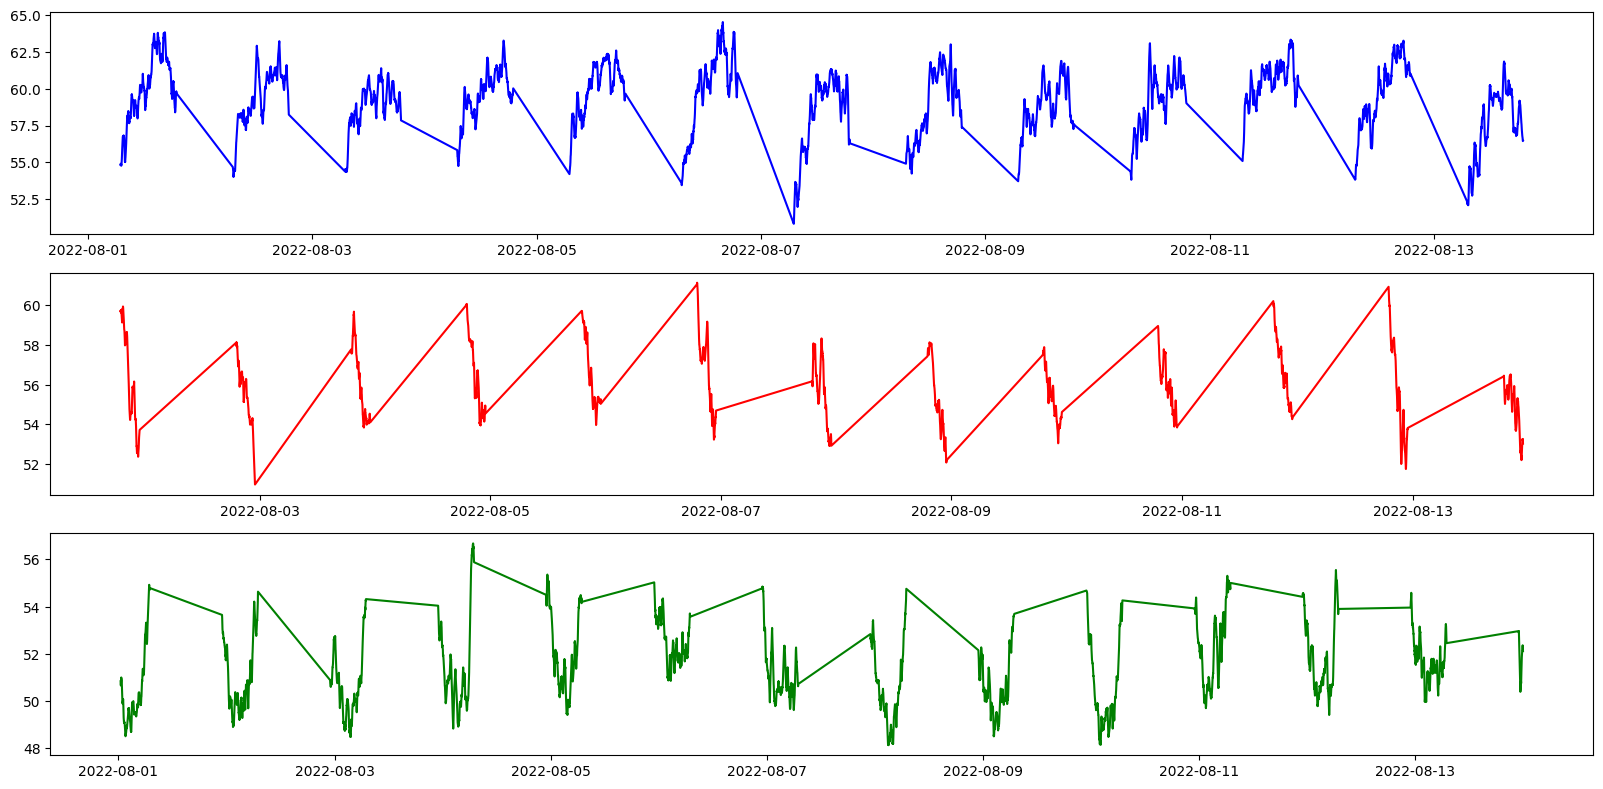

In [21]:
# Compute indices of timestamps
day_index_for_sm_data = compute_period_indices(df_chosen_sensors, '07:00', '19:00')
evening_index_for_sm_data = compute_period_indices(df_chosen_sensors, '19:00', '23:00')
night_index_for_sm_data = compute_period_indices(df_chosen_sensors, '23:00', '7:00')

fig, axs = plt.subplots(3, 1, figsize=(16, 8))
axs[0].plot(df_chosen_sensors.index[day_index_for_sm_data], df_chosen_sensors.iloc[day_index_for_sm_data]['average'],c='blue', label='Ensemble Average - Day Period')
axs[1].plot(df_chosen_sensors.index[evening_index_for_sm_data], df_chosen_sensors.iloc[evening_index_for_sm_data]['average'],c='red', label='Ensemble Average - Evening Period')
axs[2].plot(df_chosen_sensors.index[night_index_for_sm_data], df_chosen_sensors.iloc[night_index_for_sm_data]['average'],c='green', label='Ensemble Average - Night Period')

plt.tight_layout()
plt.show()

In [37]:
model = AutoTS(
    forecast_length=15,
    frequency='min',
    prediction_interval=0.95,
    ensemble=None,
    models_mode='deep',
    model_list = ['ARIMA', 'UnivariateRegression','FBProphet'],
    max_generations=5,
    num_validations=2,
    no_negatives=True,
    n_jobs=2)

In [23]:
from autots.models.model_list import model_lists
print(model_lists.keys())

dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best', 'motifs', 'all_result_path', 'regressions'])


In [38]:
model.fit(df_chosen_sensors['average'])

Model Number: 1 with model ARIMA in generation 0 of 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/clig8d9u.json


Model Number: 2 with model FBProphet in generation 0 of 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/1jsxm47t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45381', 'data', 'file=/tmp/tmpt6c76tdc/clig8d9u.json', 'init=/tmp/tmpt6c76tdc/1jsxm47t.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modelb6ukg8re/prophet_model-20230517172225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/kuovfdfj.json


Model Number: 3 with model FBProphet in generation 0 of 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/1j68dm0q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81194', 'data', 'file=/tmp/tmpt6c76tdc/kuovfdfj.json', 'init=/tmp/tmpt6c76tdc/1j68dm0q.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_model69ynii1z/prophet_model-20230517172229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 4 with model UnivariateRegression in generation 0 of 5
Model Number: 5 with model ARIMA in generation 0 of 5
Model Number: 6 with model UnivariateRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 6 in generation 0: UnivariateRegression
Model Number: 7 with model FBProphet in generation 0 of 5
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 7 in generation 0: FBProphet
Model Number: 8 with model FBProphet in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.57669e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


back_forecast split 1 failed with ValueError('LastValueNaive training dataframe has no data: (0, 1)')
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 8 in generation 0: FBProphet
Model Number: 9 with model UnivariateRegression in generation 0 of 5
Model Number: 10 with model UnivariateRegression in generation 0 of 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/s5t8jqhk.json


Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 10 in generation 0: UnivariateRegression
Model Number: 11 with model FBProphet in generation 0 of 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/o9jxmwga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58152', 'data', 'file=/tmp/tmpt6c76tdc/s5t8jqhk.json', 'init=/tmp/tmpt6c76tdc/o9jxmwga.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modelk09ceju_/prophet_model-20230517172331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 12 with model ARIMA in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 12 in generation 0: ARIMA
Model Number: 13 with model UnivariateRegression in generation 0 of 5


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


Template Eval Error: ValueError('Input X contains NaN.\nLinearSVR does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values') in model 13 in generation 0: UnivariateRegression
Model Number: 14 with model UnivariateRegression in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 14 in generation 0: UnivariateRegression
Model Number: 15 with model UnivariateRegression in generation 0 of 5

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/sg4sttie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/bn4je2xz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88226', 'data', 'file=/tmp/tmpt6c76tdc/sg4sttie.json', 'init=/tmp/tmpt6c76tdc/bn4je2xz.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modeleihvzb5y/prophet_model-20230517172354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:23:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 17 with model ARIMA in generation 0 of 5
Model Number: 18 with model UnivariateRegression in generation 0 of 5
Model Number: 19 with model ARIMA in generation 0 of 5
New Generation: 1 of 5
Model Number: 20 with model ARIMA in generation 1 of 5
Model Number: 21 with model UnivariateRegression in generation 1 of 5
Model Number: 22 with model UnivariateRegression in generation 1 of 5
Model Number: 23 with model ARIMA in generation 1 of 5
Model Number: 24 with model UnivariateRegression in generation 1 of 5
Template Eval Error: Exception('Transformer AnomalyRemoval failed on fit') in model 24 in generation 1: UnivariateRegression
Model Number: 25 with model UnivariateRegression in generation 1 of 5
Model Number: 26 with model ARIMA in generation 1 of 5
Model Number: 27 with model FBProphet in generation 1 of 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/dpozfog0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/nlkqapyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42984', 'data', 'file=/tmp/tmpt6c76tdc/dpozfog0.json', 'init=/tmp/tmpt6c76tdc/nlkqapyn.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modelpfpf_koi/prophet_model-20230517172653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 28 with model ARIMA in generation 1 of 5
Model Number: 29 with model ARIMA in generation 1 of 5
Model Number: 30 with model ARIMA in generation 1 of 5
Model Number: 31 with model ARIMA in generation 1 of 5
Model Number: 32 with model FBProphet in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 32 in generation 1: FBProphet
Model Number: 33 with model UnivariateRegression in generation 1 of 5
Model Number: 34 with model ARIMA in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 34 in generation 1: ARIMA
New Generation: 2 of 5
Model Number: 35 with model ARIMA in generation 2 of 5
Model Number: 36 with model ARIMA in generation 2 of 5
Model Number: 37 with model UnivariateRegression in generation 2 of 5
Model Number: 38 with model ARIMA in generation 2 of 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/zjctm3qy.json


Model Number: 39 with model FBProphet in generation 2 of 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/uelo_5i1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97701', 'data', 'file=/tmp/tmpt6c76tdc/zjctm3qy.json', 'init=/tmp/tmpt6c76tdc/uelo_5i1.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modely9ywyg4h/prophet_model-20230517173738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:37:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:37:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 40 with model UnivariateRegression in generation 2 of 5
Model Number: 41 with model UnivariateRegression in generation 2 of 5
Model Number: 42 with model ARIMA in generation 2 of 5
Model Number: 43 with model ARIMA in generation 2 of 5
Model Number: 44 with model ARIMA in generation 2 of 5
Model Number: 45 with model FBProphet in generation 2 of 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/rgv3bfac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/9x_s3eof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81488', 'data', 'file=/tmp/tmpt6c76tdc/rgv3bfac.json', 'init=/tmp/tmpt6c76tdc/9x_s3eof.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modelku527nr4/prophet_model-20230517173814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 46 with model UnivariateRegression in generation 2 of 5
Model Number: 47 with model UnivariateRegression in generation 2 of 5
Model Number: 48 with model ARIMA in generation 2 of 5
Model Number: 49 with model UnivariateRegression in generation 2 of 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


New Generation: 3 of 5
Model Number: 50 with model FBProphet in generation 3 of 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/a1rda77o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/aiwepizz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42141', 'data', 'file=/tmp/tmpt6c76tdc/a1rda77o.json', 'init=/tmp/tmpt6c76tdc/aiwepizz.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modelck3sunmq/prophet_model-20230517173848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Model Number: 51 with model FBProphet in generation 3 of 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/6m8u8p8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/9dm8epus.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49455', 'data', 'file=/tmp/tmpt6c76tdc/6m8u8p8h.json', 'init=/tmp/tmpt6c76tdc/9dm8epus.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modeltzyk3s97/prophet_model-20230517173851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:39:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 52 with model ARIMA in generation 3 of 5
Model Number: 53 with model ARIMA in generation 3 of 5
Model Number: 54 with model ARIMA in generation 3 of 5
Model Number: 55 with model ARIMA in generation 3 of 5
Model Number: 56 with model UnivariateRegression in generation 3 of 5
Model Number: 57 with model UnivariateRegression in generation 3 of 5
Model Number: 58 with model UnivariateRegression in generation 3 of 5
Model Number: 59 with model ARIMA in generation 3 of 5
Model Number: 60 with model ARIMA in generation 3 of 5
Model Number: 61 with model ARIMA in generation 3 of 5
Model Number: 62 with model ARIMA in generation 3 of 5
Model Number: 63 with model UnivariateRegression in generation 3 of 5
Model Number: 64 with model FBProphet in generation 3 of 5
Template Eval Error: Exception('Transformer AnomalyRemoval failed on fit') in model 64 in generation 3: FBProphet
New Generation: 4 of 5


/usr/local/lib/python3.10/dist-packages/autots/tools/window_functions.py:468: RuntimeWarning: divide by zero encountered in true_divide
  slope = (sxy - sx * sy) / (sx2 - sx**2)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.10/dist-packages/autots/tools/transform.py:3069: RuntimeWarning: invalid value encountered in add
  return df - (self.slope * self.dates_2d + self.intercept)


Model Number: 65 with model ARIMA in generation 4 of 5
Model Number: 66 with model UnivariateRegression in generation 4 of 5
Model Number: 67 with model ARIMA in generation 4 of 5
Model Number: 68 with model ARIMA in generation 4 of 5
Model Number: 69 with model UnivariateRegression in generation 4 of 5
Model Number: 70 with model ARIMA in generation 4 of 5
Model Number: 71 with model ARIMA in generation 4 of 5
Model Number: 72 with model UnivariateRegression in generation 4 of 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/qnw6w6d2.json


Model Number: 73 with model FBProphet in generation 4 of 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/qm72_jid.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73468', 'data', 'file=/tmp/tmpt6c76tdc/qnw6w6d2.json', 'init=/tmp/tmpt6c76tdc/qm72_jid.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_model9bfhu4qu/prophet_model-20230517174559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 74 with model ARIMA in generation 4 of 5
Model Number: 75 with model UnivariateRegression in generation 4 of 5
Model Number: 76 with model UnivariateRegression in generation 4 of 5
Model Number: 77 with model UnivariateRegression in generation 4 of 5
Model Number: 78 with model ARIMA in generation 4 of 5
Model Number: 79 with model ARIMA in generation 4 of 5
New Generation: 5 of 5
Model Number: 80 with model ARIMA in generation 5 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 80 in generation 5: ARIMA
Model Number: 81 with model ARIMA in generation 5 of 5
Model Number: 82 with model ARIMA in generation 5 of 5
Template Eval Error: Exception('Transformer Cointegration failed on fit') in model 82 in generation 5: ARIMA
Model Number: 83 with model ARIMA in generation 5 of 5
Model Number: 84 with model ARIMA in generation 5 of 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Model Number: 85 with model FBProphet in generation 5 of 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/xrg1gu9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/c3gv9jq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96215', 'data', 'file=/tmp/tmpt6c76tdc/xrg1gu9z.json', 'init=/tmp/tmpt6c76tdc/c3gv9jq7.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modelxq9b5yga/prophet_model-20230517175106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Number: 86 with model ARIMA in generation 5 of 5
Model Number: 87 with model UnivariateRegression in generation 5 of 5
Model Number: 88 with model UnivariateRegression in generation 5 of 5
Model Number: 89 with model ARIMA in generation 5 of 5
Model Number: 90 with model ARIMA in generation 5 of 5
Model Number: 91 with model ARIMA in generation 5 of 5
Ensembling Error: KeyError('TotalRuntime')
Validation Round: 1
Model Number: 1 of 14 with model ARIMA for Validation 1
📈 1 - ARIMA with avg smape 1.12: 
Model Number: 2 of 14 with model ARIMA for Validation 1
2 - ARIMA with avg smape 1.13: 
Model Number: 3 of 14 with model ARIMA for Validation 1
3 - ARIMA with avg smape 1.12: 
Model Number: 4 of 14 with model ARIMA for Validation 1
📈 4 - ARIMA with avg smape 1.03: 
Model Number: 5 of 14 with model ARIMA for Validation 1
5 - ARIMA with avg smape 1.06: 
Model Number: 6 of 14 with model ARIMA for Validation 1
6 - ARIMA with avg smape 1.19: 
Model Number: 7 of 14 with model UnivariateRe

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/4c7fgzyf.json


9 - UnivariateRegression with avg smape 2.01: 
Model Number: 10 of 14 with model FBProphet for Validation 1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/_5gavkse.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79123', 'data', 'file=/tmp/tmpt6c76tdc/4c7fgzyf.json', 'init=/tmp/tmpt6c76tdc/_5gavkse.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modelo4_rduf9/prophet_model-20230517180333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


10 - FBProphet with avg smape 1.35: 
Model Number: 11 of 14 with model UnivariateRegression for Validation 1
11 - UnivariateRegression with avg smape 1.93: 
Model Number: 12 of 14 with model UnivariateRegression for Validation 1
📈 12 - UnivariateRegression with avg smape 0.97: 
Model Number: 13 of 14 with model UnivariateRegression for Validation 1
13 - UnivariateRegression with avg smape 2.08: 
Model Number: 14 of 14 with model FBProphet for Validation 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/bgf38_2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/7hrkvytd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80687', 'data', 'file=/tmp/tmpt6c76tdc/bgf38_2l.json', 'init=/tmp/tmpt6c76tdc/7hrkvytd.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modelt80krvuv/prophet_model-20230517180341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:03:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:03:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


14 - FBProphet with avg smape 2.98: 
Validation Round: 2
Model Number: 1 of 14 with model ARIMA for Validation 2
📈 1 - ARIMA with avg smape 0.91: 
Model Number: 2 of 14 with model ARIMA for Validation 2
📈 2 - ARIMA with avg smape 0.73: 
Model Number: 3 of 14 with model ARIMA for Validation 2
3 - ARIMA with avg smape 0.76: 
Model Number: 4 of 14 with model ARIMA for Validation 2
4 - ARIMA with avg smape 0.86: 
Model Number: 5 of 14 with model ARIMA for Validation 2
5 - ARIMA with avg smape 1.03: 
Model Number: 6 of 14 with model ARIMA for Validation 2
6 - ARIMA with avg smape 1.22: 
Model Number: 7 of 14 with model UnivariateRegression for Validation 2
7 - UnivariateRegression with avg smape 1.49: 
Model Number: 8 of 14 with model UnivariateRegression for Validation 2
8 - UnivariateRegression with avg smape 2.13: 
Model Number: 9 of 14 with model UnivariateRegression for Validation 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/_6p76v6b.json


9 - UnivariateRegression with avg smape 2.13: 
Model Number: 10 of 14 with model FBProphet for Validation 2


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/_2matzw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22648', 'data', 'file=/tmp/tmpt6c76tdc/_6p76v6b.json', 'init=/tmp/tmpt6c76tdc/_2matzw4.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_modelo2haaptf/prophet_model-20230517181223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


10 - FBProphet with avg smape 1.76: 
Model Number: 11 of 14 with model UnivariateRegression for Validation 2
11 - UnivariateRegression with avg smape 2.92: 
Model Number: 12 of 14 with model UnivariateRegression for Validation 2
12 - UnivariateRegression with avg smape 2.17: 
Model Number: 13 of 14 with model UnivariateRegression for Validation 2
13 - UnivariateRegression with avg smape 3.08: 
Model Number: 14 of 14 with model FBProphet for Validation 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/hnsqsgqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt6c76tdc/scywxsy_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55969', 'data', 'file=/tmp/tmpt6c76tdc/hnsqsgqx.json', 'init=/tmp/tmpt6c76tdc/scywxsy_.json', 'output', 'file=/tmp/tmpt6c76tdc/prophet_model03uawhxw/prophet_model-20230517181229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


14 - FBProphet with avg smape 4.56: 
Ensembling Error: KeyError('TotalRuntime')


Initiated AutoTS object with best model: 
ARIMA
{'fillna': 'rolling_mean', 'transformations': {'0': 'ClipOutliers', '1': 'PositiveShift'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 3, 'fillna': None}, '1': {}}}
{'p': 4, 'd': 0, 'q': 1, 'regression_type': None}
Validation: 0, 1, 2
SMAPE: 0.11561081757369325, 1.1274362452720412, 0.7275587365346071
MAE: 0.06036197495201302, 0.5761285205812475, 0.3696436072710057
SPL: 0.9496894594270482, 1.0204520923234681, 1.0151566040537725

In [39]:
model.export_template(
    "model.csv",
    models="best",
    max_per_model_class=1,
    include_results=True,
)

In [36]:
model

Initiated AutoTS object with best model: 
ARIMA
{'fillna': 'ffill_mean_biased', 'transformations': {'0': 'ClipOutliers'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 3.5, 'fillna': None}}}
{'p': 3, 'd': 0, 'q': 2, 'regression_type': None}
Validation: 0, 1, 2
SMAPE: 0.11613232064104699, 1.1152011807572084, 0.7233455242511597
MAE: 0.060641272163423326, 0.5699286725704994, 0.3675130748266298
SPL: 0.9498047078284891, 1.0206026707484785, 1.0153587903775607

In [34]:
forecast_length = 60*24
prediction = model.predict(forecast_length=forecast_length)

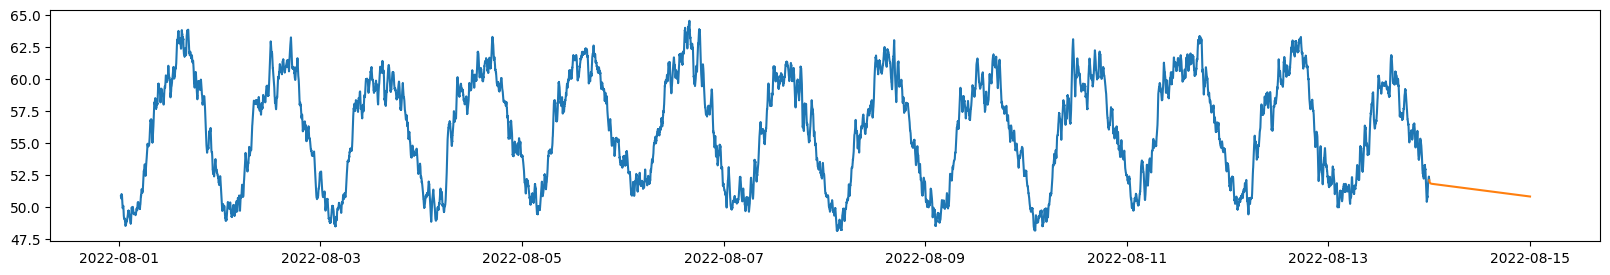

In [35]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(df_chosen_sensors['average'])
ax.plot(prediction.forecast)

In [31]:
prediction.forecast
a = 60*24

,average
2022-08-14 00:00:00,52.075820
2022-08-14 00:01:00,52.042129
2022-08-14 00:02:00,52.012589
2022-08-14 00:03:00,51.986921
2022-08-14 00:04:00,51.964500
2022-08-14 00:05:00,51.944948
2022-08-14 00:06:00,51.927868
2022-08-14 00:07:00,51.912943
2022-08-14 00:08:00,51.899886
2022-08-14 00:09:00,51.888452
